In [1]:
import localSettings as ls
from load_data_run123 import *
from unblinding_far_sideband import *
from matplotlib import pyplot as plt

In [3]:
fold = "nuselection"
tree = "NeutrinoSelectionFilter"

fnu   = ls.ntuple_path + "tutorial/prodgenie_bnb_nu_uboone_overlay_mcc9.1_v08_00_00_26_filter_run1_reco2_reco2.root"
fext  = ls.ntuple_path + "tutorial/data_extbnb_mcc9.1_v08_00_00_25_reco2_C_all_reco2.root"
fdata = ls.ntuple_path + "tutorial/data_bnb_mcc9.1_v08_00_00_25_reco2_C1_beam_good_reco2_5e19.root"

unu   = uproot.open(fnu)[fold][tree]
uext  = uproot.open(fext)[fold][tree]
udata = uproot.open(fdata)[fold][tree]

vardict = get_variables()
variables = ['_opfilter_pe_beam','_opfilter_pe_veto','nslice','selected',\
             'shr_energy_tot_cali','n_tracks_contained','shr_energy_tot_cali',\
             'trk_energy_tot','nu_pdg','ccnc','category']
#variables = vardict['VARIABLES']+vardict['NUEVARS']+vardict['RCVRYVARS'] #this adds many more variables...
variables = list(set(variables))

print("nu dataframe")
nu   = unu.pandas.df(variables+vardict['WEIGHTS']+vardict['SYSTVARS'], flatten=False)
print("ext dataframe")
ext  = uext.pandas.df(variables, flatten=False)
print("data dataframe")
data = udata.pandas.df(variables, flatten=False)

nu dataframe
ext dataframe
data dataframe


In [4]:
print(variables)

['_opfilter_pe_veto', 'category', '_opfilter_pe_beam', 'shr_energy_tot_cali', 'ccnc', 'nu_pdg', 'trk_energy_tot', 'n_tracks_contained', 'selected', 'nslice']


In [5]:
uproot_v = [unu,uext,udata]
df_v = [nu,ext,data]

In [6]:
INTERCEPT = 0.0
SLOPE = 0.83

# define some energy-related variables
print("vars3")
for i,df in enumerate(df_v):
    df["reco_e"] = (df["shr_energy_tot_cali"] + INTERCEPT) / SLOPE + df["trk_energy_tot"]
#    df['protonenergy_corr'] = df['protonenergy']+0.000620/df['protonenergy']-0.001792
#    df.loc[(df['protonenergy_corr']>9998.), 'protonenergy_corr'] = 0
#    df['electron_e'] = (df["shr_energy_tot_cali"] + INTERCEPT) / SLOPE

# and a way to filter out data
for i,df in enumerate(df_v):
    df["bnbdata"] = np.zeros_like(df["nslice"])
    df["extdata"] = np.zeros_like(df["nslice"])
data["bnbdata"] = np.ones_like(data["nslice"])
ext["extdata"] = np.ones_like(ext["nslice"])

vars3


In [7]:
#for i,df in enumerate(df_v):
#    up = uproot_v[i]
#    print("uproot",i)
#    process_uproot(up,df)    
#    #print("uproot_recoveryvars",i)
#    #process_uproot_recoveryvars(up,df)    

#print("vars1")
#for i,df in enumerate(df_v):
#    df['subcluster'] = df['shrsubclusters0'] + df['shrsubclusters1'] + df['shrsubclusters2']
#    df['trkfit'] = df['shr_tkfit_npointsvalid'] / df['shr_tkfit_npoints']
#    # and the 2d angle difference
#    df['anglediff_Y'] = np.abs(df['secondshower_Y_dir']-df['shrclusdir2'])
#    df['anglediff_V'] = np.abs(df['secondshower_V_dir']-df['shrclusdir1'])
#    df['anglediff_U'] = np.abs(df['secondshower_U_dir']-df['shrclusdir0'])
#    df['cos_shr_theta'] = np.cos(df['shr_theta'])

#print("vars2")
#for i,df in enumerate(df_v):
#    df['shr_tkfit_nhits_tot'] = (df['shr_tkfit_nhits_Y']+df['shr_tkfit_nhits_U']+df['shr_tkfit_nhits_V'])
#    df.loc[:,'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_Y']
#    df.loc[(df['shr_tkfit_nhits_U']>df['shr_tkfit_nhits_Y']),'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_U']
#    df.loc[(df['shr_tkfit_nhits_V']>df['shr_tkfit_nhits_Y']) & (df['shr_tkfit_nhits_V']>df['shr_tkfit_nhits_U']),'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_V']
#    df['shr_tkfit_gap10_nhits_tot'] = (df['shr_tkfit_gap10_nhits_Y']+df['shr_tkfit_gap10_nhits_U']+df['shr_tkfit_gap10_nhits_V'])
#    df.loc[:,'shr_tkfit_gap10_dedx_max'] = df['shr_tkfit_gap10_dedx_Y']
#    df.loc[(df['shr_tkfit_gap10_nhits_U']>df['shr_tkfit_gap10_nhits_Y']),'shr_tkfit_gap10_dedx_max'] = df['shr_tkfit_gap10_dedx_U']
#    df.loc[(df['shr_tkfit_gap10_nhits_V']>df['shr_tkfit_gap10_nhits_Y']) & (df['shr_tkfit_gap10_nhits_V']>df['shr_tkfit_gap10_nhits_U']),'shr_tkfit_gap10_dedx_max'] = df['shr_tkfit_gap10_dedx_V']
    
#print("done")

In [8]:
# fix weights that are out of scale
for i,df in enumerate([nu]):
    df.loc[ df['weightSplineTimesTune'] <= 0, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] == np.inf, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] > 100, 'weightSplineTimesTune' ] = 1.
    df.loc[ np.isnan(df['weightSplineTimesTune']) == True, 'weightSplineTimesTune' ] = 1.

In [9]:
import plotter
import importlib
importlib.reload(plotter)

nue = nu.query('abs(nu_pdg) == 12 and ccnc == 0')

samples = {'mc': nu, 'nue': nue, 'ext': ext, 'data': data}
weights = {'mc': 0.03465648854961832, 'nue': 0.03465648854961832, 'ext': 0.15396097438639594}

plotter = plotter.Plotter(samples, weights, pot=4.54e+19)

/uboone/app/users/cthorpe/PELEE/plotter.py:288: UserWarning: Missing dirt sample
  warnings.warn("Missing dirt sample")


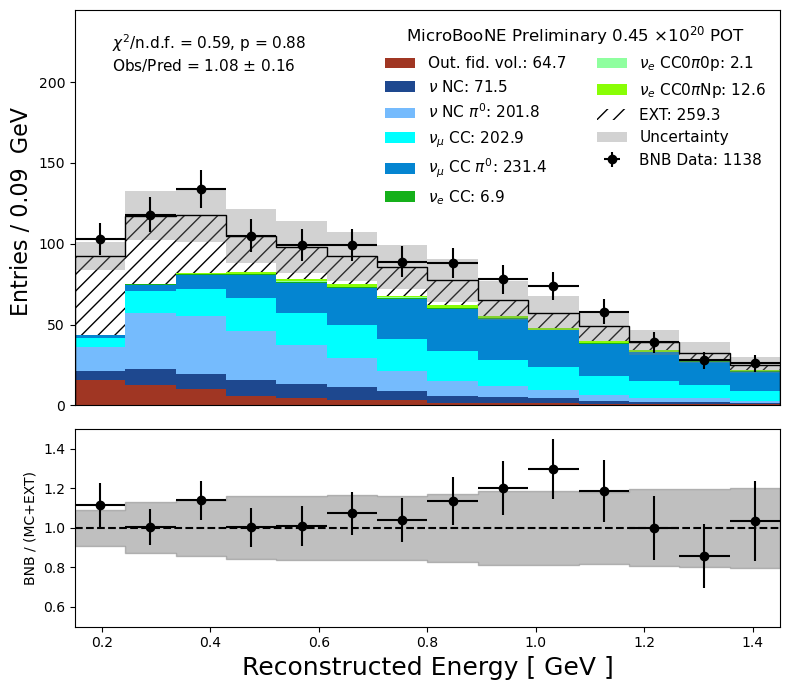

In [13]:
DETSYS = {'mc':False,'nue':False,'ccpi0':False,'ncpi0':False,'dirt':False,\
          'ncnopi':False,'nccpi':False,'ncpi0':False,'ccpi0':False}

SEL = '( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1)'
SEL += ' and nslice==1 and selected==1 and shr_energy_tot_cali > 0.07'
SEL += ' and n_tracks_contained>0'

VARIABLE, BINS, RANGE, XTIT = 'reco_e',14,(0.15, 1.45),r"Reconstructed Energy [ GeV ]" # ~reproduce Fig. 36 of PeLEE TN!
#VARIABLE, BINS, RANGE, XTIT = 'reco_e',[0,0.5,0.8,1.5],None,r"Reconstructed Energy [ GeV ]"
#VARIABLE, BINS, RANGE, XTIT = 'n_tracks_contained',5,(-0.5,4.5),r"Reconstructed Energy [ GeV ]"

fig, ax1, ax2 = plotter.plot_variable(
    VARIABLE,   
    query=SEL,
    kind="event_category",
    draw_sys=True,
    detsysdict=DETSYS,
    ratio=True,
    stacksort=3,
    title=XTIT,
    bins=BINS,
    range=RANGE,
    chisq=True,
)[0:3]

ax1.set_title('', loc='left')
ax1.set_ylim(0, ax1.get_ylim()[1]*1.6)

plt.tight_layout()
